In [1]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
#load up both the training set and the test set
train = pd.read_csv('train(1).csv', index_col = 'Id')
test = pd.read_csv('test_house_prices.csv', index_col = 'Id')

In [3]:
#removing SalePrice column from the training set and setting it up as Y
Y = train['SalePrice'].values
train.drop('SalePrice', axis = 1, inplace = True)

In [4]:
#concatenate training set and test set, one hot encode using pd.get_dummies, and splitting it up again; using length of
#the training set to splice by index, all this while avoiding dummy variable trap by drop_first = True
len_train = len(train)
X_train_test = pd.concat([train, test])
X_train_test_ohe = pd.get_dummies(X_train_test, drop_first=True)

X_train_ohe, X_test_ohe = X_train_test_ohe.iloc[:len_train, :], X_train_test_ohe.iloc[len_train:, :]


In [5]:
X_train_ohe.head(2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [6]:
#fill nan values in bot trainig set and test set with zeros, set X as X_train_ohe.values and add a column of ones
X_train_ohe.fillna(value=0, inplace=True)
X_test_ohe.fillna(value=0, inplace=True)
X = X_train_ohe.values
to_predict = X_test_ohe.values
X = np.append(arr=np.ones((len(X_train_ohe),1)).astype(int), values = X, axis = 1)
to_predict = np.append(arr=np.ones((len(X_test_ohe),1)).astype(int), values = to_predict, axis = 1)

C:\Users\schiejak.UVN\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [7]:
#splitting the data to be able to train the model, 20% test size
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [8]:
#backward elimination using just p-values, since I did not find a way to return two values from a function
#(aside from the tuple) i chose to split it to three functions, which feels more clear,
#to current version of me anyway...
def backward_elimination_train(x, sl):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y_train, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    print('Number of columns, train set: {}'.format(len(x[0])))
                    
                    
    return x



def backward_elimination_test(x, sl):
    x_test = to_predict
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y_train, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    x_test = np.delete(x_test, j, 1)
                    print('Number of columns, train set: {}; number of rows: {}'.format(len(x[0]), len(x)))
                    print('Number of columns, test set: {}'.format(len(x_test[0])))
                    
    return x_test

def backward_elimination_X_test(x, sl):
    x_test = X_test
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y_train, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    x_test = np.delete(x_test, j, 1)
                    print('Number of columns, train set: {}; number of rows: {}'.format(len(x[0]), len(x)))
                    print('Number of columns, test set: {}'.format(len(x_test[0])))
                    
    return x_test

SL = 0.05

In [ ]:
#Running the functions, for some reason they sometimes produce sets with +-1 column values
#difference, which is fixed by rerunning said function. Therefore I left the debugging in place to check this.

In [ ]:
model_X_test = backward_elimination_X_test(X_train, SL)

In [ ]:
model_train = backward_elimination_train(X_train, SL)

In [ ]:
model_test = backward_elimination_test(X_train, SL)

In [14]:
#Function for optimizing n_estimators value of random forest regressor model
def RFR_optimizer(number):
    plot_data_x = []
    plot_data_y = []
    for i in range(1, number):
        reg = RandomForestRegressor(n_estimators = i, criterion = 'mae', random_state = 0)
        reg.fit(model_train, y_train)
        RFR_pred_i = reg.predict(model_X_test)
        error = mean_absolute_error(y_test, RFR_pred_i)
        print('Number of estimators {}, mean error {}'.format(i, error))
        plot_data_x.append(i)
        plot_data_y.append(error)
    plt.figure(figsize = (20,10))    
    plt.plot(plot_data_x, plot_data_y, label = 'Random Forest Regression')
    plt.xlabel('Mean Absolute Error')
    plt.ylabel('Number of Estimators')
    print('Optimal n_estimators for tested range of values equals {}'.format((plot_data_y.index(min(plot_data_y))) + 1))
    print('Minimal value among achieved mean absolute errors is {}'.format(min(plot_data_y)))
    return plot_data_y.index(min(plot_data_y)) + 1

Number of estimators 1, mean error 28999.102739726026
Number of estimators 2, mean error 23853.116438356163
Number of estimators 3, mean error 20533.80821917808
Number of estimators 4, mean error 18081.06678082192
Optimal n_estimators for tested range of values equals 4
Minimal value among achieved mean absolute errors is 18081.06678082192


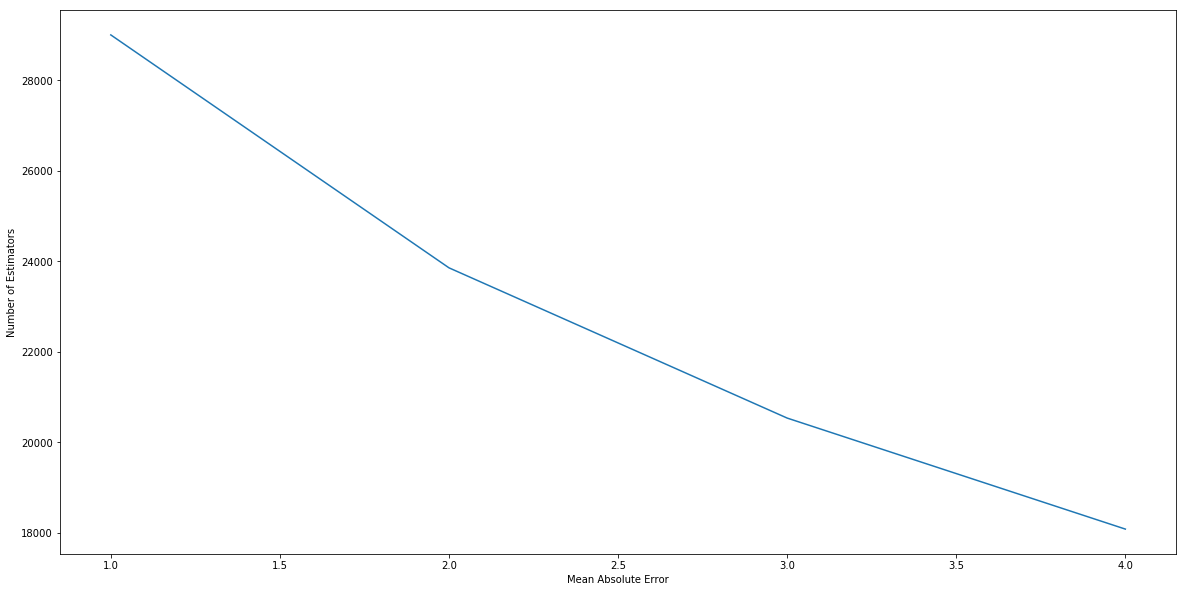

In [15]:
RFR_opt = RFR_optimizer(5)

In [22]:
#Defining the optimal RFR and predicting
RF_regressor = RandomForestRegressor(n_estimators = RFR_opt, criterion = 'mae', random_state = 0)
RF_regressor.fit(model_train, y_train)
predictions = reg.predict(model_X_test)

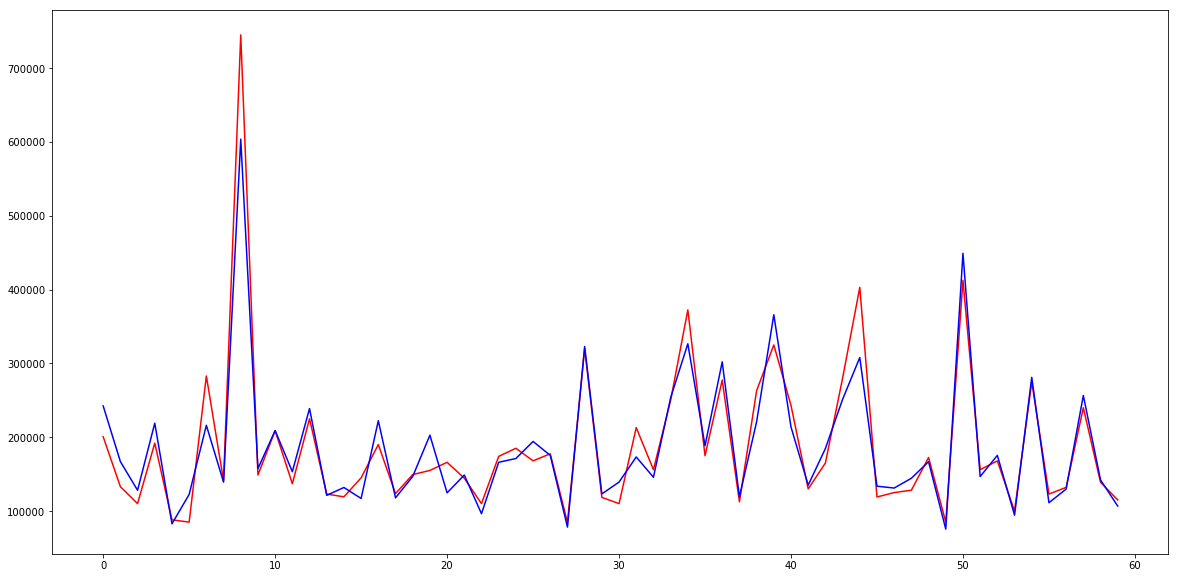

In [23]:
#Plotting first 60 predictions (blue) to compare with actual values (red)
size = 60
plt.figure(figsize = (20,10))
ax1 = plt.plot(y_test[:size], 'r')
plt.plot(predictions[:size], 'b')

In [66]:
#Function to build a kaggle .csv file ready to submit without any 
#need for additional editing (aside from specifying which model would you like to use for that). 
def kaggle_csv(): 
    with open('kaggle_house_prices_submission.csv', 'w') as f: 
        f.write('Id,SalePrice\n') 
         
    with open('kaggle_house_prices_submission.csv', 'a') as f: 
        prediction = RF_regressor.predict(model_test)
        for imid, data in enumerate(prediction): 
            imid = imid + 1461 
            f.write('{},{}\n'.format(imid, data)) 


In [80]:
#Creating the submission .csv
kaggle_csv()